In [1]:
# import necessary libraries
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from tqdm import tqdm
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from torchvision.transforms import Lambda

In [2]:
class UltrasoundDataset(Dataset):
    '''
    Custom dataset class for ultrasound images
    '''
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join('..',self.dataframe.iloc[idx, 0])

        image = Image.open(img_name)
        if image.mode == 'RGBA':
            image = image.convert('RGB')

        if self.transform:
            image = self.transform(image)

        label = self.dataframe.iloc[idx, 1]
        return image, label

In [ ]:
class FocalLoss(torch.nn.Module):
    '''
    Focal loss function
    '''
    def __init__(self, alpha=1, gamma=2, logits=False, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = torch.nn.functional.binary_cross_entropy_with_logits(inputs, targets, reduce=False)
        else:
            BCE_loss = torch.nn.functional.binary_cross_entropy(inputs, targets, reduce=False)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

In [15]:
class ClassificationTrainer:
    def __init__(self, model,epochs, criterion, optimizer,
                 train_dataloader,val_dataloader,model_save_dir,use_scheduler=False, displ_print=True, pbar_visible=False):
        # attributes
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.train_dataloader = train_dataloader
        self.epochs = epochs
        self.val_data_loader = val_dataloader
        self.model_save_dir = model_save_dir
        self.use_scheduler = use_scheduler
        self.displ_print = displ_print
        self.pbar_visible = pbar_visible


        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        if use_scheduler:
            self.lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

        # send model to device
        self.model.to(self.device)

        # check if model directory exits, otherwise create one
        if not os.path.exists(self.model_save_dir):
            os.makedirs(self.model_save_dir)


    def train(self):
        # put model in train mode
        self.model.train()

        with tqdm(range(self.epochs),disable=not self.pbar_visible) as pbar:
            for epoch in pbar:
                # running sum of loss and accuracy
                loss_list = []
                acc_list = []
                for i, (img, label) in enumerate(self.train_dataloader):
                    # set gradient to zero
                    self.optimizer.zero_grad()

                    # send to device
                    img = img.to(self.device)       # [batch_size, 3, 256, 256]
                    label = label.to(self.device)   # [batch_size,]

                    # forward pass
                    output = self.model(img)        # output: [batch_size, 3]
                    
                    loss = self.criterion(output, label)

                    # backward pass
                    loss.backward()

                    self.optimizer.step()

                    # calculate and add 
                    acc = accuracy_score(label.detach().cpu().numpy(),
                                          torch.argmax(torch.softmax(output,dim=-1),dim=-1).detach().cpu().numpy())
                    
                    # append loss and accuracy
                    loss_list.append(loss.item())
                    acc_list.append(acc)
                
                # calculate validation loss and accuracy
                val_loss, val_acc = self.validate()

                # calculate train loss and accuracy
                loss_list = torch.tensor(loss_list)
                acc_list = torch.tensor(acc_list)
                train_loss = torch.mean(loss_list)
                train_acc = torch.mean(acc_list)

                # take schedular step
                if self.use_scheduler:
                    self.lr_scheduler.step()

                if self.displ_print:
                    print(f'Epoch {epoch} Train Loss: {train_loss} Train Accuracy: {train_acc}, Val Loss: {val_loss}, Val Accuracy: {val_acc}')
                pbar.set_description(f'Train Loss: {train_loss}, Val Loss: {val_loss}')
                pbar.update(1)

            # save model
            torch.save(self.model, os.path.join(self.model_save_dir, 'model.pth'))

    
    def validate(self):

        # put model in eval mode
        self.model.eval()

        # keep list of true and predicted labels
        y_true = []
        y_pred = []
        loss_list = []

        with torch.no_grad():
            for i, (img, label) in enumerate(self.val_data_loader):
                # send image to device
                img = img.to(self.device)    # [batch_size, 3, 256, 256]
                label = label.to(self.device)   # [batch_size,]

                # forward pass
                output = self.model(img)    # [batch_size, 1]

                # y_true
                y_true.extend(label.cpu().numpy().tolist())

                # y_pred
                # y_pred.extend(torch.argmax(torch.softmax(output,dim=-1),dim=-1).detach().cpu().numpy())
                y_pred.extend(torch.argmax(output,dim=-1).detach().cpu().numpy())

                # calculate loss
                loss_ = self.criterion(output, label).item()

                loss_list.append(loss_)

        # calculate loss
        loss_list = torch.tensor(loss_list)
        loss = torch.mean(loss_list)

        # calculate accuracy
        acc = accuracy_score(y_true, y_pred)

        # put model back in train mode
        self.model.train()

        return loss, acc 
         

In [22]:
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# Define the preprocessing transforms
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    #grayscale to RGB since the model was trained on RGB images
    Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x),  # Convert grayscale to RGB
    # Normalize the image using the mean and standard deviation of the ImageNet dataset
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the dataframe
df_path = os.path.join('..','Dataset_BUSI_with_GT','dataset.csv')
df = pd.read_csv(df_path)

# Split the dataset into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Create the training and validation datasets
train_dataset = UltrasoundDataset(train_df, transform=transforms)
val_dataset = UltrasoundDataset(val_df, transform=transforms)

# Create the training and validation dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True)

#print train and validation dataset sizes
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

Train dataset size: 624
Validation dataset size: 157


Original class labels values count
0  - Normal
1  - Benign
2  - Malignant
true_label_num
1    0.560819
2    0.268886
0    0.170294
Name: proportion, dtype: float64


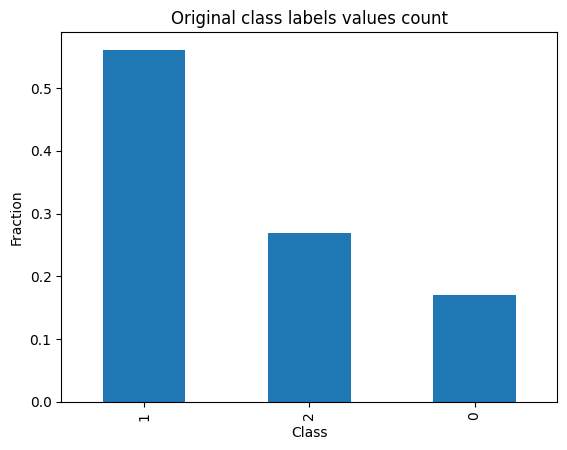

In [28]:
print("Original class labels values count")
print(0, ' - Normal')
print(1, ' - Benign')
print(2, ' - Malignant')
print(df['true_label_num'].value_counts(normalize=True))

df['true_label_num'].value_counts(normalize=True).plot(kind='bar', title='Original class labels values count',xlabel='Class', ylabel='Fraction')

plt.show()

In [24]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42

torch.manual_seed(SEED)
np.random.seed(SEED)

resnet50 = models.resnet50(weights='ResNet50_Weights.DEFAULT')

model = torch.nn.Sequential(
    resnet50,
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(1000, 3)
)

# # freeze resnet layers
# for param in model[0].parameters():
#     param.requires_grad = False

# # unfreeze last layer and layer before last
# for param in model[0].fc.parameters():
#     param.requires_grad = True
# for param in model[0].layer4.parameters():
#     param.requires_grad = True

# move model to device
model = model.to(DEVICE)

# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
            [{'params': model[0].parameters(),'lr': 9e-5},
            #  {'params': model[0].layer4.parameters(),'lr': 9e-5},
             {'params': model[1].parameters(),'lr': 9e-4}],weight_decay=1e-2)

trainer = ClassificationTrainer(
    model=model, epochs=10, criterion=criterion, optimizer=optimizer,
    train_dataloader=train_dataloader, val_dataloader=val_dataloader,
    model_save_dir='ResNet50', use_scheduler= True ,pbar_visible=False, displ_print=True)

In [30]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42

torch.manual_seed(SEED)
np.random.seed(SEED)

resnet50 = models.resnet50(weights='ResNet50_Weights.DEFAULT')

model = torch.nn.Sequential(
    resnet50,
    torch.nn.ReLU(),
    torch.nn.Dropout(0.7),
    torch.nn.Linear(1000, 3)
)

# # freeze resnet layers
# for param in model[0].parameters():
#     param.requires_grad = False

# # unfreeze last layer and layer before last
# for param in model[0].fc.parameters():
#     param.requires_grad = True
# for param in model[0].layer4.parameters():
#     param.requires_grad = True

# move model to device
model = model.to(DEVICE)

# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss(weight=torch.tensor([1.0/0.1702, 1.0/0.5608, 1.0/0.2688]).to(DEVICE))

optimizer = torch.optim.Adam(
            [{'params': model[0].parameters(),'lr': 9e-5},
            #  {'params': model[0].layer4.parameters(),'lr': 9e-5},
             {'params': model[1].parameters(),'lr': 9e-4}],weight_decay=1)

trainer = ClassificationTrainer(
    model=model, epochs=20, criterion=criterion, optimizer=optimizer,
    train_dataloader=train_dataloader, val_dataloader=val_dataloader,
    model_save_dir='ResNet50', use_scheduler= True ,pbar_visible=False, displ_print=True)

trainer.train()

Epoch 0 Train Loss: 1.120693564414978 Train Accuracy: 0.3365384638309479, Val Loss: 1.097797155380249, Val Accuracy: 0.3630573248407643
Epoch 1 Train Loss: 1.1112961769104004 Train Accuracy: 0.3541666567325592, Val Loss: 1.0842570066452026, Val Accuracy: 0.42038216560509556
Epoch 2 Train Loss: 1.0797510147094727 Train Accuracy: 0.4134615361690521, Val Loss: 1.0741212368011475, Val Accuracy: 0.4267515923566879
Epoch 3 Train Loss: 1.0708415508270264 Train Accuracy: 0.42307692766189575, Val Loss: 1.0734714269638062, Val Accuracy: 0.45222929936305734
Epoch 4 Train Loss: 1.030146598815918 Train Accuracy: 0.49839743971824646, Val Loss: 1.0438711643218994, Val Accuracy: 0.5095541401273885
Epoch 5 Train Loss: 0.9760264158248901 Train Accuracy: 0.5368589758872986, Val Loss: 0.995935320854187, Val Accuracy: 0.5668789808917197
Epoch 6 Train Loss: 0.8999583125114441 Train Accuracy: 0.6137820482254028, Val Loss: 0.9037631154060364, Val Accuracy: 0.6369426751592356
Epoch 7 Train Loss: 0.832177758216

In [31]:
!pip install torchcam

   ---------------------------------------- 0.0/46.0 kB ? eta -:--:--
   ---------------------------------------- 46.0/46.0 kB 2.2 MB/s eta 0:00:00


In [32]:
from torchcam.methods import GradCAM

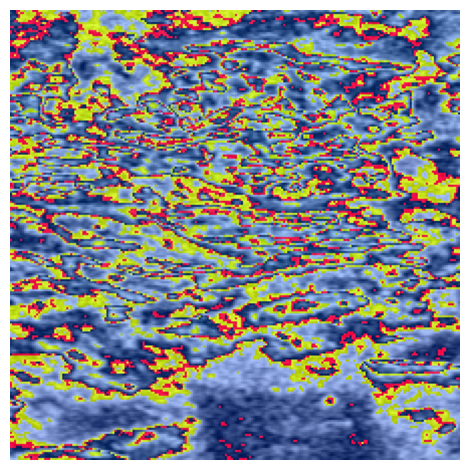

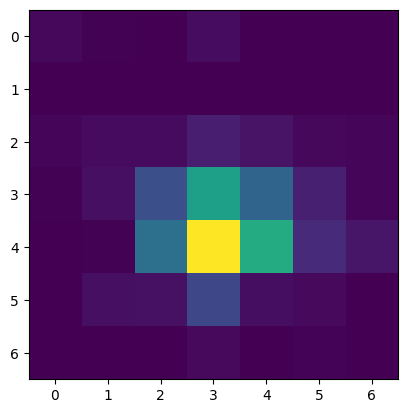

In [62]:
import matplotlib.pyplot as plt
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image
with GradCAM(model) as cam_extractor:
    for img, label in val_dataloader:
        img = img[:1].to(DEVICE)
        label = label.to(DEVICE)
        out = model(img)

        activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)
        # plt.imshow(img[0].permute(1, 2, 0).cpu().numpy()); plt.axis('off'); plt.tight_layout(); plt.show()
        result = overlay_mask(to_pil_image(img[0]), to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.99)
        # Display it
        plt.imshow(result); plt.axis('off'); plt.tight_layout(); plt.show()
        break


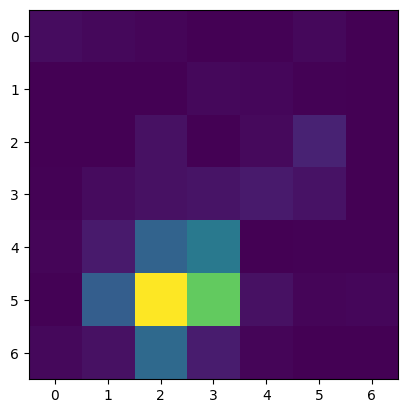

In [29]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42

torch.manual_seed(SEED)
np.random.seed(SEED)

resnet50 = models.resnet50(weights='ResNet50_Weights.DEFAULT')

model = torch.nn.Sequential(
    resnet50,
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(1000, 3)
)

# # freeze resnet layers
# for param in model[0].parameters():
#     param.requires_grad = False

# # unfreeze last layer and layer before last
# for param in model[0].fc.parameters():
#     param.requires_grad = True
# for param in model[0].layer4.parameters():
#     param.requires_grad = True

# move model to device
model = model.to(DEVICE)

# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss(weight=torch.tensor([1.0/0.1702, 1.0/0.5608, 1.0/0.2688]).to(DEVICE))

optimizer = torch.optim.Adam(
            [{'params': model[0].parameters(),'lr': 9e-5},
            #  {'params': model[0].layer4.parameters(),'lr': 9e-5},
             {'params': model[1].parameters(),'lr': 9e-4}],weight_decay=1e-2)

trainer = ClassificationTrainer(
    model=model, epochs=20, criterion=criterion, optimizer=optimizer,
    train_dataloader=train_dataloader, val_dataloader=val_dataloader,
    model_save_dir='ResNet50', use_scheduler= True ,pbar_visible=False, displ_print=True)

trainer.train()

Epoch 0 Train Loss: 1.0448442697525024 Train Accuracy: 0.4407051205635071, Val Loss: 1.0573452711105347, Val Accuracy: 0.5605095541401274
Epoch 1 Train Loss: 0.7704606652259827 Train Accuracy: 0.7291666865348816, Val Loss: 0.8394204378128052, Val Accuracy: 0.6751592356687898
Epoch 2 Train Loss: 0.41647809743881226 Train Accuracy: 0.8621794581413269, Val Loss: 0.6165239810943604, Val Accuracy: 0.7388535031847133
Epoch 3 Train Loss: 0.19786182045936584 Train Accuracy: 0.9471153616905212, Val Loss: 0.5977664589881897, Val Accuracy: 0.7834394904458599
Epoch 4 Train Loss: 0.07995311915874481 Train Accuracy: 0.9855769276618958, Val Loss: 0.5534657835960388, Val Accuracy: 0.821656050955414
Epoch 5 Train Loss: 0.05865028128027916 Train Accuracy: 0.9823718070983887, Val Loss: 0.620698094367981, Val Accuracy: 0.7834394904458599
Epoch 6 Train Loss: 0.042681846767663956 Train Accuracy: 0.9935897588729858, Val Loss: 0.5964847803115845, Val Accuracy: 0.8152866242038217
Epoch 7 Train Loss: 0.03827629

In [27]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42

torch.manual_seed(SEED)
np.random.seed(SEED)

resnet50 = models.resnet50(weights='ResNet50_Weights.DEFAULT')

model = torch.nn.Sequential(
    resnet50,
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(1000, 3)
)

# # freeze resnet layers
# for param in model[0].parameters():
#     param.requires_grad = False

# # unfreeze last layer and layer before last
# for param in model[0].fc.parameters():
#     param.requires_grad = True
# for param in model[0].layer4.parameters():
#     param.requires_grad = True

# move model to device
model = model.to(DEVICE)

# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
            [{'params': model[0].parameters(),'lr': 9e-5},
            #  {'params': model[0].layer4.parameters(),'lr': 9e-5},
             {'params': model[1].parameters(),'lr': 9e-4}],weight_decay=1e-2)

trainer = ClassificationTrainer(
    model=model, epochs=20, criterion=criterion, optimizer=optimizer,
    train_dataloader=train_dataloader, val_dataloader=val_dataloader,
    model_save_dir='ResNet50', use_scheduler= True ,pbar_visible=False, displ_print=True)

trainer.train()

Epoch 0 Train Loss: 0.9564518928527832 Train Accuracy: 0.5416666865348816, Val Loss: 0.9468573331832886, Val Accuracy: 0.5796178343949044
Epoch 1 Train Loss: 0.6556714177131653 Train Accuracy: 0.7227563858032227, Val Loss: 0.6572545766830444, Val Accuracy: 0.7006369426751592
Epoch 2 Train Loss: 0.3812462389469147 Train Accuracy: 0.8461538553237915, Val Loss: 0.6046830415725708, Val Accuracy: 0.7197452229299363
Epoch 3 Train Loss: 0.21698014438152313 Train Accuracy: 0.9519230723381042, Val Loss: 0.5507458448410034, Val Accuracy: 0.7707006369426752
Epoch 4 Train Loss: 0.098183773458004 Train Accuracy: 0.9855769276618958, Val Loss: 0.6519745588302612, Val Accuracy: 0.7515923566878981
Epoch 5 Train Loss: 0.05873904004693031 Train Accuracy: 0.9855769276618958, Val Loss: 0.5504425764083862, Val Accuracy: 0.7961783439490446
Epoch 6 Train Loss: 0.04867084324359894 Train Accuracy: 0.9839743375778198, Val Loss: 0.6495943069458008, Val Accuracy: 0.7770700636942676
Epoch 7 Train Loss: 0.0443641133

In [26]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42

torch.manual_seed(SEED)
np.random.seed(SEED)

resnet50 = models.resnet50(weights='ResNet50_Weights.DEFAULT')

model = torch.nn.Sequential(
    resnet50,
    torch.nn.Linear(1000, 3)
)

# # freeze resnet layers
# for param in model[0].parameters():
#     param.requires_grad = False

# # unfreeze last layer and layer before last
# for param in model[0].fc.parameters():
#     param.requires_grad = True
# for param in model[0].layer4.parameters():
#     param.requires_grad = True

# move model to device
model = model.to(DEVICE)

# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
            [{'params': model[0].parameters(),'lr': 9e-5},
            #  {'params': model[0].layer4.parameters(),'lr': 9e-5},
             {'params': model[1].parameters(),'lr': 9e-4}],weight_decay=1e-2)

trainer = ClassificationTrainer(
    model=model, epochs=20, criterion=criterion, optimizer=optimizer,
    train_dataloader=train_dataloader, val_dataloader=val_dataloader,
    model_save_dir='ResNet50', use_scheduler= True ,pbar_visible=False, displ_print=True)

trainer.train()

Epoch 0 Train Loss: 0.8435541987419128 Train Accuracy: 0.6185897588729858, Val Loss: 0.844803512096405, Val Accuracy: 0.554140127388535
Epoch 1 Train Loss: 0.3856877386569977 Train Accuracy: 0.8605769276618958, Val Loss: 0.6615283489227295, Val Accuracy: 0.6942675159235668
Epoch 2 Train Loss: 0.09396325051784515 Train Accuracy: 0.9807692170143127, Val Loss: 0.6169503331184387, Val Accuracy: 0.7707006369426752
Epoch 3 Train Loss: 0.06476913392543793 Train Accuracy: 0.9823718070983887, Val Loss: 0.7047978639602661, Val Accuracy: 0.7579617834394905
Epoch 4 Train Loss: 0.04302465543150902 Train Accuracy: 0.9839743375778198, Val Loss: 0.6093271970748901, Val Accuracy: 0.7961783439490446
Epoch 5 Train Loss: 0.0398968905210495 Train Accuracy: 0.9871794581413269, Val Loss: 0.6545416116714478, Val Accuracy: 0.7770700636942676
Epoch 6 Train Loss: 0.055774860084056854 Train Accuracy: 0.9839743375778198, Val Loss: 0.6091498732566833, Val Accuracy: 0.7643312101910829
Epoch 7 Train Loss: 0.057688225

In [25]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42

torch.manual_seed(SEED)
np.random.seed(SEED)

resnet50 = models.resnet50(weights='ResNet50_Weights.DEFAULT')

model = torch.nn.Sequential(
    resnet50,
    torch.nn.Linear(1000, 3)
)

# # freeze resnet layers
# for param in model[0].parameters():
#     param.requires_grad = False

# # unfreeze last layer and layer before last
# for param in model[0].fc.parameters():
#     param.requires_grad = True
# for param in model[0].layer4.parameters():
#     param.requires_grad = True

# move model to device
model = model.to(DEVICE)

# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
            [{'params': model[0].parameters(),'lr': 9e-5},
            #  {'params': model[0].layer4.parameters(),'lr': 9e-5},
             {'params': model[1].parameters(),'lr': 9e-4}],weight_decay=1e-3)

trainer = ClassificationTrainer(
    model=model, epochs=10, criterion=criterion, optimizer=optimizer,
    train_dataloader=train_dataloader, val_dataloader=val_dataloader,
    model_save_dir='ResNet50', use_scheduler= True ,pbar_visible=False, displ_print=True)

trainer.train()

Epoch 0 Train Loss: 0.8472028970718384 Train Accuracy: 0.6362179517745972, Val Loss: 0.8599385023117065, Val Accuracy: 0.5796178343949044
Epoch 1 Train Loss: 0.34506529569625854 Train Accuracy: 0.8846153616905212, Val Loss: 0.6451917290687561, Val Accuracy: 0.7197452229299363
Epoch 2 Train Loss: 0.109440378844738 Train Accuracy: 0.9743589758872986, Val Loss: 0.7255718111991882, Val Accuracy: 0.7515923566878981
Epoch 3 Train Loss: 0.05176303908228874 Train Accuracy: 0.9855769276618958, Val Loss: 0.7414231300354004, Val Accuracy: 0.7898089171974523
Epoch 4 Train Loss: 0.0425654761493206 Train Accuracy: 0.9839743375778198, Val Loss: 0.7939106822013855, Val Accuracy: 0.7388535031847133
Epoch 5 Train Loss: 0.02786952443420887 Train Accuracy: 0.9919871687889099, Val Loss: 0.7808129191398621, Val Accuracy: 0.7579617834394905
Epoch 6 Train Loss: 0.018740538507699966 Train Accuracy: 0.9935897588729858, Val Loss: 0.6181325912475586, Val Accuracy: 0.7707006369426752
Epoch 7 Train Loss: 0.02279157

In [21]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

resnet50 = models.resnet50(weights='ResNet50_Weights.DEFAULT')

model = torch.nn.Sequential(
    resnet50,
    torch.nn.Linear(1000, 3)
)

# # freeze resnet layers
# for param in model[0].parameters():
#     param.requires_grad = False

# # unfreeze last layer and layer before last
# for param in model[0].fc.parameters():
#     param.requires_grad = True
# for param in model[0].layer4.parameters():
#     param.requires_grad = True

# move model to device
model = model.to(DEVICE)

# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
            [{'params': model[0].parameters(),'lr': 9e-5},
            #  {'params': model[0].layer4.parameters(),'lr': 9e-5},
             {'params': model[1].parameters(),'lr': 9e-4}])

trainer = ClassificationTrainer(
    model=model, epochs=10, criterion=criterion, optimizer=optimizer,
    train_dataloader=train_dataloader, val_dataloader=val_dataloader,
    model_save_dir='ResNet50', use_scheduler= True ,pbar_visible=False, displ_print=True)


trainer.train()

Epoch 0 Train Loss: 0.8658421039581299 Train Accuracy: 0.6362179517745972, Val Loss: 0.8577319383621216, Val Accuracy: 0.6242038216560509
Epoch 1 Train Loss: 0.34691479802131653 Train Accuracy: 0.8637820482254028, Val Loss: 0.7236078977584839, Val Accuracy: 0.7133757961783439
Epoch 2 Train Loss: 0.14352348446846008 Train Accuracy: 0.9519230723381042, Val Loss: 0.8577200174331665, Val Accuracy: 0.7133757961783439
Epoch 3 Train Loss: 0.06874378025531769 Train Accuracy: 0.9791666865348816, Val Loss: 0.9144750833511353, Val Accuracy: 0.7133757961783439
Epoch 4 Train Loss: 0.03064757212996483 Train Accuracy: 0.9935897588729858, Val Loss: 0.7978137731552124, Val Accuracy: 0.7834394904458599
Epoch 5 Train Loss: 0.021816862747073174 Train Accuracy: 0.9903846383094788, Val Loss: 0.6167303323745728, Val Accuracy: 0.7961783439490446
Epoch 6 Train Loss: 0.02251538448035717 Train Accuracy: 0.9903846383094788, Val Loss: 0.7099691033363342, Val Accuracy: 0.8089171974522293
Epoch 7 Train Loss: 0.01628

In [19]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

resnet50 = models.resnet50(weights='ResNet50_Weights.DEFAULT')

model = torch.nn.Sequential(
    resnet50,
    torch.nn.Linear(1000, 3)
)

# freeze resnet layers
for param in model[0].parameters():
    param.requires_grad = False

# unfreeze last layer and layer before last
for param in model[0].fc.parameters():
    param.requires_grad = True
for param in model[0].layer4.parameters():
    param.requires_grad = True

# move model to device
model = model.to(DEVICE)

# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
            [{'params': model[0].fc.parameters(),'lr': 9e-5},
             {'params': model[0].layer4.parameters(),'lr': 9e-5},
             {'params': model[1].parameters(),'lr': 9e-4}])

trainer = ClassificationTrainer(
    model=model, epochs=10, criterion=criterion, optimizer=optimizer,
    train_dataloader=train_dataloader, val_dataloader=val_dataloader,
    model_save_dir='ResNet50', use_scheduler= True ,pbar_visible=False, displ_print=True)

trainer.train()

Epoch 0 Train Loss: 0.8594871163368225 Train Accuracy: 0.6105769276618958, Val Loss: 1.000042200088501, Val Accuracy: 0.5414012738853503
Epoch 1 Train Loss: 0.4541345238685608 Train Accuracy: 0.8349359035491943, Val Loss: 0.721806526184082, Val Accuracy: 0.6560509554140127
Epoch 2 Train Loss: 0.24557560682296753 Train Accuracy: 0.9134615659713745, Val Loss: 0.7979662418365479, Val Accuracy: 0.6687898089171974
Epoch 3 Train Loss: 0.09619902074337006 Train Accuracy: 0.9727563858032227, Val Loss: 0.9857961535453796, Val Accuracy: 0.6878980891719745
Epoch 4 Train Loss: 0.0776352807879448 Train Accuracy: 0.9759615659713745, Val Loss: 1.1798373460769653, Val Accuracy: 0.6751592356687898
Epoch 5 Train Loss: 0.06923725455999374 Train Accuracy: 0.9775640964508057, Val Loss: 0.8114157915115356, Val Accuracy: 0.7070063694267515
Epoch 6 Train Loss: 0.029999030753970146 Train Accuracy: 0.9967948794364929, Val Loss: 0.9516758918762207, Val Accuracy: 0.7070063694267515
Epoch 7 Train Loss: 0.036718972

In [14]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

resnet50 = models.resnet50(weights='ResNet50_Weights.DEFAULT')

model = torch.nn.Sequential(
    resnet50,
    torch.nn.Linear(1000, 3)
)

# freeze resnet layers
for param in model[0].parameters():
    param.requires_grad = False

# unfreeze last layer and layer before last
for param in model[0].fc.parameters():
    param.requires_grad = True
for param in model[0].layer4.parameters():
    param.requires_grad = True

# move model to device
model = model.to(DEVICE)

# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
            [{'params': model[0].fc.parameters(),'lr': 9e-5},
             {'params': model[0].layer4.parameters(),'lr': 9e-5},
             {'params': model[1].parameters(),'lr': 9e-4}])

trainer = ClassificationTrainer(
    model=model, epochs=10, criterion=criterion, optimizer=optimizer,
    train_dataloader=train_dataloader, val_dataloader=val_dataloader,
    model_save_dir='ResNet50' ,pbar_visible=False, displ_print=True)

# trainer.train()

Epoch 0 Train Loss: 0.8791989088058472 Train Accuracy: 0.6137820482254028, Val Loss: 0.8621851801872253, Val Accuracy: 0.5605095541401274
Epoch 1 Train Loss: 0.45563527941703796 Train Accuracy: 0.8253205418586731, Val Loss: 0.7423765063285828, Val Accuracy: 0.6369426751592356
Epoch 2 Train Loss: 0.22844111919403076 Train Accuracy: 0.9182692170143127, Val Loss: 0.7608102560043335, Val Accuracy: 0.6815286624203821
Epoch 3 Train Loss: 0.09927414357662201 Train Accuracy: 0.9743589758872986, Val Loss: 0.7795428037643433, Val Accuracy: 0.7070063694267515
Epoch 4 Train Loss: 0.052979376167058945 Train Accuracy: 0.9839743375778198, Val Loss: 0.8753034472465515, Val Accuracy: 0.7006369426751592
Epoch 5 Train Loss: 0.045278891921043396 Train Accuracy: 0.9855769276618958, Val Loss: 0.9793837666511536, Val Accuracy: 0.732484076433121
Epoch 6 Train Loss: 0.06159568950533867 Train Accuracy: 0.9791666865348816, Val Loss: 0.7946264147758484, Val Accuracy: 0.7261146496815286
Epoch 7 Train Loss: 0.02051